In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) because it's not open source. You can download it from kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition later on.

First, install the Kaggle API by uncommenting the following line and executing it.

In [ ]:
#! pip install kaggle

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and cick on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, then execute the next two instructions (don't uncomment the first if the '.kaggle' directory has already been created).

In [ ]:
#! mkdir ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You just need to accept to go on its main page and accept its rules, then uncomment the following instructions to download and unzip the data.

In [ ]:
path = Path(Config.get_key('data_path')).expanduser()/'planet'
os.makedirs(path, exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/planet')

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
#! unzip {path}/train_v2.csv.zip -d {path}

 99%|███████████████████████████████████████▋| 595M/600M [00:17<00:00, 28.7MB/s]
100%|████████████████████████████████████████| 600M/600M [00:17<00:00, 35.0MB/s]
  0%|                                                | 0.00/159k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 1.88MB/s]
Archive:  /home/ubuntu/.fastai/data/planet/train_v2.csv.zip
  inflating: /home/ubuntu/.fastai/data/planet/train_v2.csv  
   creating: /home/ubuntu/.fastai/data/planet/__MACOSX/
  inflating: /home/ubuntu/.fastai/data/planet/__MACOSX/._train_v2.csv  


We only download the training data file for this lesson, but you can grab the test file if you want to make a late submission.

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it.

In [ ]:
#! sudo apt-get install p7zip-full

And now we can finally unpack the data.

In [ ]:
#! 7za x {path}/train-jpg.tar.7z -o{path}
#! tar -xf {path}/train-jpg.tar -C {path}


7-Zip (A) [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,4 CPUs)

Processing archive: /home/ubuntu/.fastai/data/planet/train-jpg.tar.7z

Extracting  train-jpg.tar

Everything is Ok

Size:       665753600
Compressed: 629296207


## Multiclassification

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (ImageFileList.from_folder(path)            
        .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')  
        .random_split_by_pct()                     
        .datasets(ImageMultiDataset)  
        .transform(tfms, size=128)             
        .databunch())

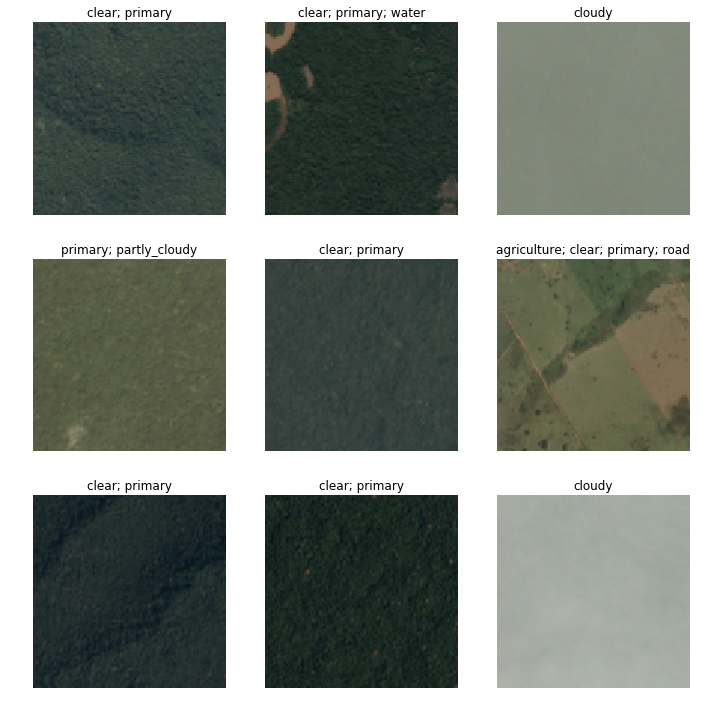

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

In [ ]:
tst = ImageFileList.from_folder(path).label_from_csv('train_v2.csv', sep=' ', folder='train', suffix='.jpg')

In [ ]:
len(tst)

40479